In [2]:
!pip install --upgrade mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import math
import random
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics
from sklearn.metrics import mean_squared_error
import yfinance as yf

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [4]:
# Downloading stock data for American Express Company (AXP) from Yahoo Finance
stock_data = yf.download('AXP', start='2020-01-01', end='2024-01-01')
specific_df = pd.DataFrame(stock_data).reset_index()
specific_df['Name'] = 'AAPL'
print(specific_df.head())

[*********************100%%**********************]  1 of 1 completed

        Date        Open        High         Low       Close   Adj Close  \
0 2020-01-02  124.660004  126.269997  124.230003  125.849998  118.922508   
1 2020-01-03  124.320000  125.099998  123.940002  124.599998  117.741325   
2 2020-01-06  123.370003  124.160004  123.120003  124.059998  117.231033   
3 2020-01-07  123.470001  124.400002  123.360001  123.410004  116.616837   
4 2020-01-08  124.050003  126.360001  123.800003  125.540001  118.629601   

    Volume  Name  
0  2708000  AAPL  
1  2090600  AAPL  
2  2855200  AAPL  
3  2042300  AAPL  
4  3458200  AAPL  


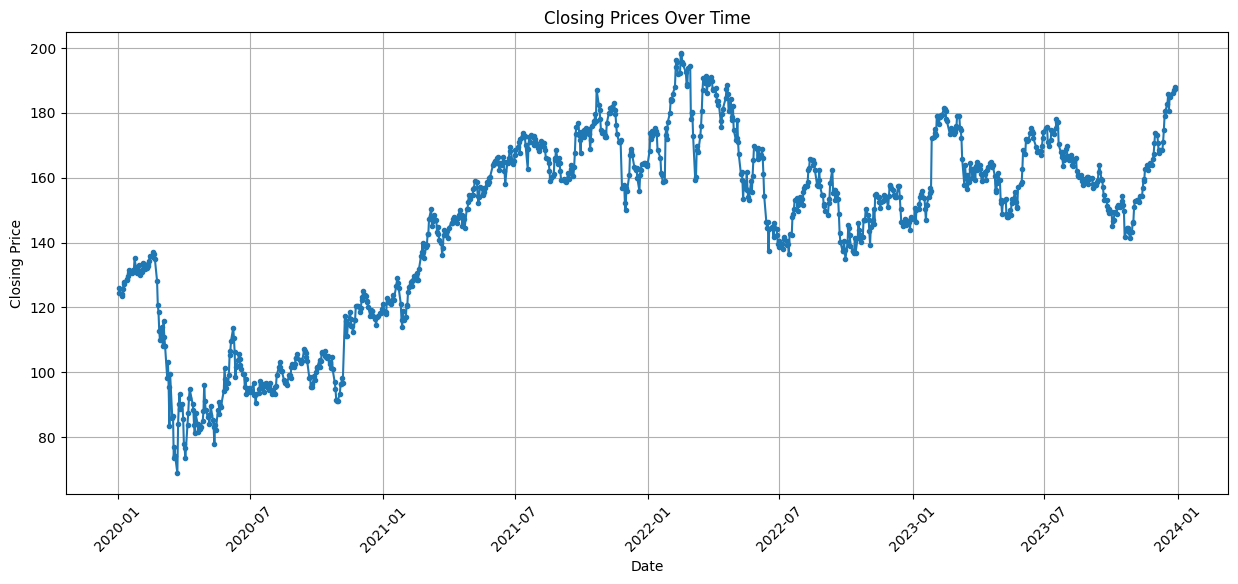

In [5]:
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

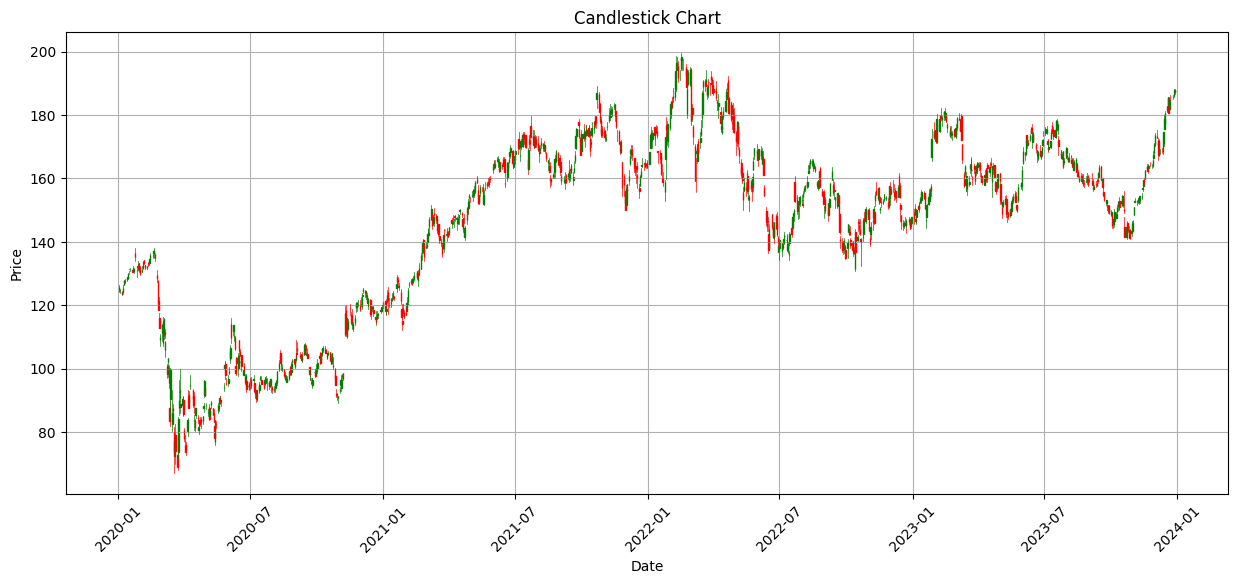

In [6]:
matplotlib_date = mdates.date2num(specific_df['Date'])
ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T
plt.figure(figsize=(15,6))
ax=plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

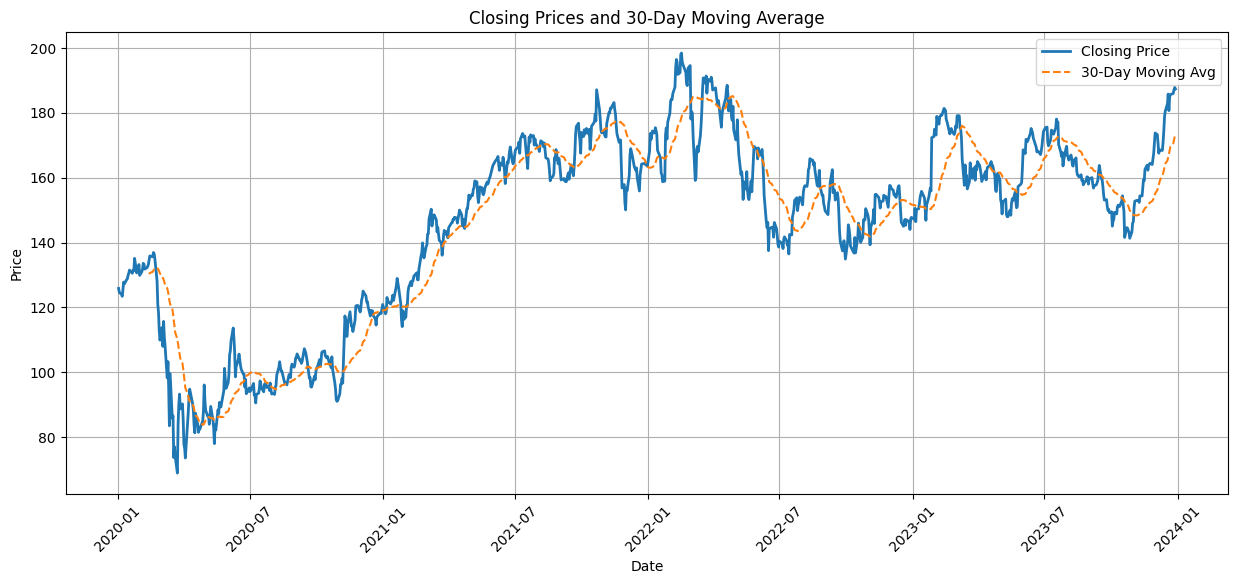

In [7]:
window = 30
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], label='Closing Price', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Close'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

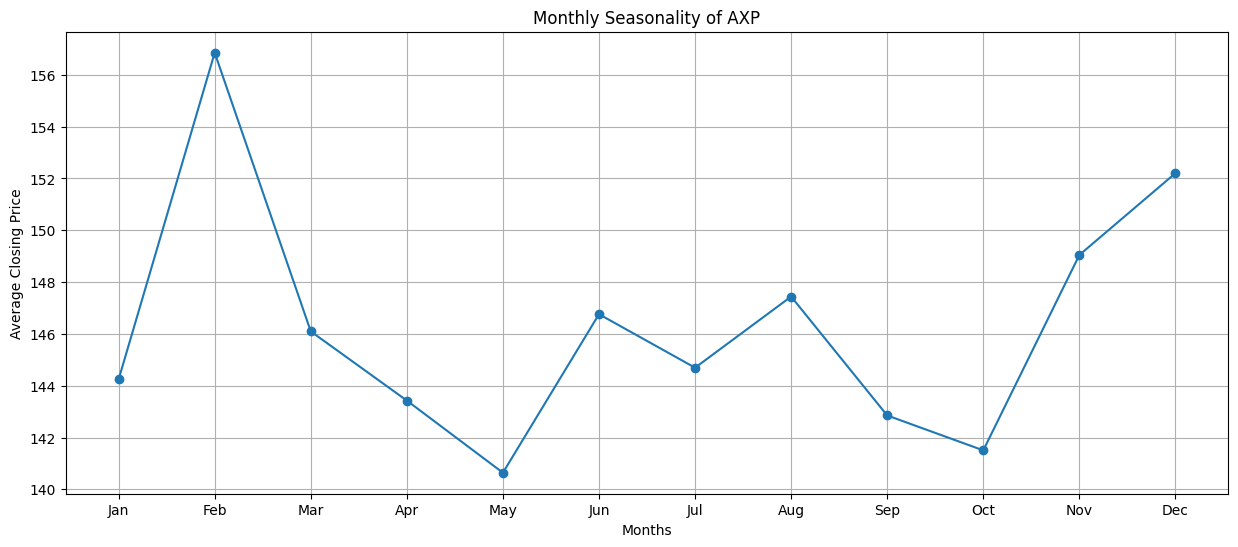

In [27]:
company_name = 'AXP'
specific_df['Month'] = specific_df['Date'].dt.month
monthly_average = specific_df.groupby('Month')['Close'].mean()

plt.figure(figsize=(15,6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of {company_name}')
plt.xlabel('Months')
plt.ylabel('Average Closing Price')
plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [9]:
new_df = specific_df.reset_index()['Close']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [10]:
from sklearn.model_selection import train_test_split
test_size = 0.2
train_data, test_data = train_test_split(scaled_data, test_size=test_size, shuffle=False)

In [11]:
def generate_sequences_and_labels(data, n_past):
    sequences = [data[i - n_past:i, 0] for i in range(n_past, len(data))]
    labels = [data[i, 0] for i in range(n_past, len(data))]
    return np.array(sequences), np.array(labels)

In [12]:
n_past = 60
x_train, y_train = generate_sequences_and_labels(train_data, n_past)
x_test, y_test = generate_sequences_and_labels(test_data, n_past)

In [13]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [14]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=[input_shape, 1]))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    return model

In [15]:
def compile_lstm_model(model):
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [16]:
def train_lstm_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=300, batch_size=32, verbose=1)

In [17]:
model = build_lstm_model(x_train.shape[1])
compile_lstm_model(model)
train_lstm_model(model, x_train, y_train, x_test, y_test)

Epoch 1/300
24/24 [==============================] - 9s 62ms/step - loss: 0.0762 - mean_absolute_error: 0.2082 - val_loss: 0.0043 - val_mean_absolute_error: 0.0546
Epoch 2/300
24/24 [==============================] - 0s 13ms/step - loss: 0.0147 - mean_absolute_error: 0.0994 - val_loss: 0.0048 - val_mean_absolute_error: 0.0594
Epoch 3/300
24/24 [==============================] - 0s 14ms/step - loss: 0.0105 - mean_absolute_error: 0.0812 - val_loss: 0.0038 - val_mean_absolute_error: 0.0524
Epoch 4/300
24/24 [==============================] - 0s 12ms/step - loss: 0.0089 - mean_absolute_error: 0.0731 - val_loss: 0.0044 - val_mean_absolute_error: 0.0524
Epoch 5/300
24/24 [==============================] - 0s 15ms/step - loss: 0.0078 - mean_absolute_error: 0.0685 - val_loss: 0.0048 - val_mean_absolute_error: 0.0534
Epoch 6/300
24/24 [==============================] - 0s 18ms/step - loss: 0.0073 - mean_absolute_error: 0.0656 - val_loss: 0.0036 - val_mean_absolute_error: 0.0517
Epoch 7/300
24/2

In [18]:
def make_predictions(model, x_train, x_test):
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)
    return train_predict, test_predict

In [19]:
train_predict, test_predict = make_predictions(model, x_train, x_test)

5/5 [==============================] - 0s 6ms/step


In [20]:
def inverse_transform(scaler, y_train, train_predict, y_test, test_predict):
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    return train_predict, test_predict

In [21]:
train_predict, test_predict = inverse_transform(scaler, y_train, train_predict, y_test, test_predict)

In [22]:
def evaluate_model(y_train, train_predict, y_test, test_predict):
    train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
    test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
    print(f"Training RMSE: {train_rmse}")
    print(f"Testing RMSE: {test_rmse}")

In [23]:
evaluate_model(y_train, train_predict, y_test, test_predict)

Training RMSE: 146.0452615238573
Testing RMSE: 162.22216625936792


In [24]:
def plot_predictions(original_data, train_predict, test_predict, company_name):
    look_back = 60
    train_predict_plot = np.empty_like(original_data)
    train_predict_plot[:] = np.nan
    train_predict_plot[look_back : len(train_predict) + look_back] = train_predict.flatten()

    test_predict_plot = np.empty_like(original_data)
    test_predict_plot[:] = np.nan
    test_start = len(original_data) - len(test_predict)
    test_predict_plot[test_start:] = test_predict.flatten()

    plt.figure(figsize=(15, 6))
    plt.plot(original_data, color='black', label=f"Actual {company_name} price")
    plt.plot(train_predict_plot, color='red', label=f'Predicted {company_name} price (train_set)')
    plt.plot(test_predict_plot, color='blue', label=f"Predicted {company_name} price (test_set)")
    plt.title(f"{company_name} share price")
    plt.xlabel("Time")
    plt.ylabel(f"{company_name} share price")
    plt.legend()
    plt.show()


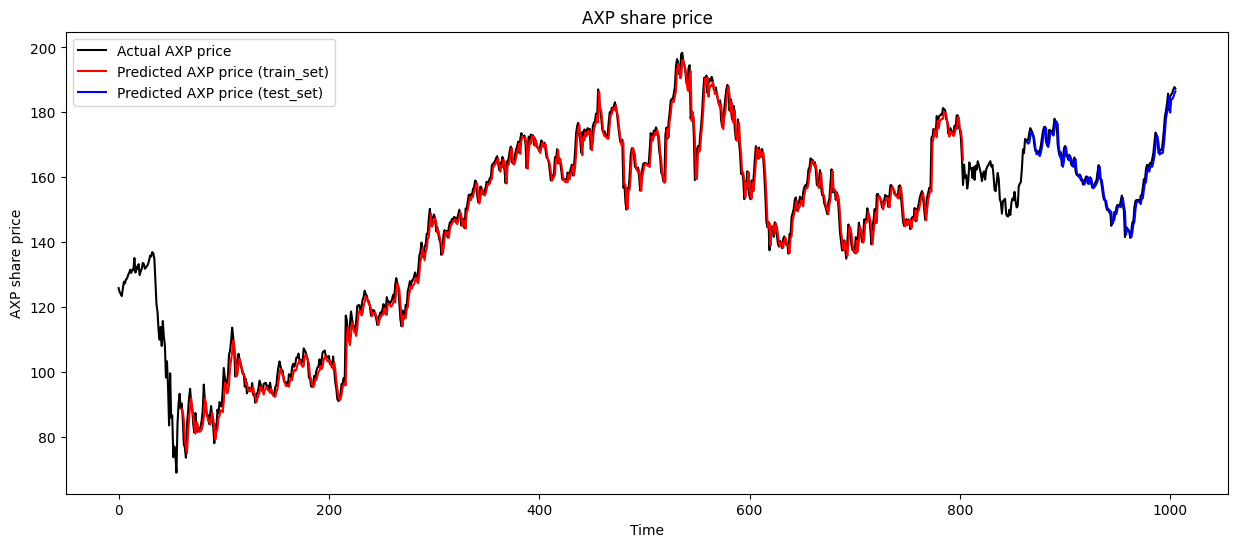

In [28]:
plot_predictions(new_df, train_predict, test_predict, company_name)

5/5 [==============================] - 0s 6ms/step
   Actual Close Prices  Predicted Close Prices
0           171.139999              170.734161
1           171.720001              170.348129
2           173.639999              170.715561
3           175.139999              172.435959
4           174.470001              173.926819


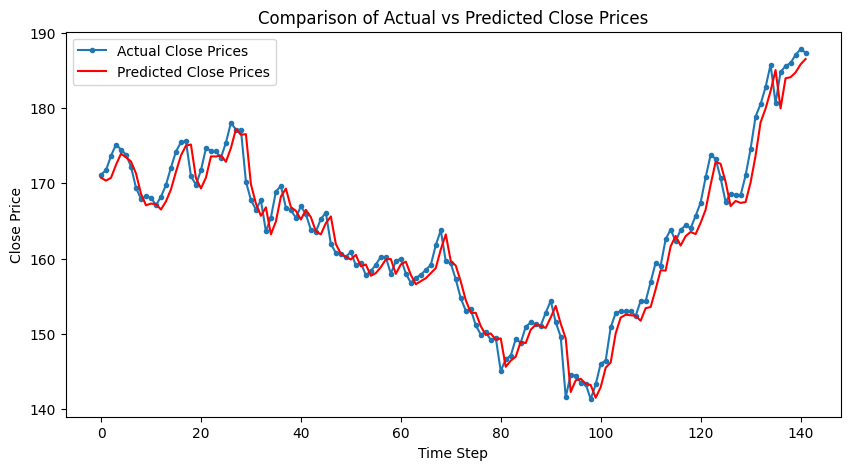

In [26]:
predictions = model.predict(x_test)

actual_values_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
predicted_values_inverse = scaler.inverse_transform(predictions)

comparison_df = pd.DataFrame({'Actual Close Prices': actual_values_inverse.flatten(), 'Predicted Close Prices': predicted_values_inverse.flatten()})
print(comparison_df.head())

plt.figure(figsize=(10, 5))
plt.plot(actual_values_inverse.flatten(), marker='.', label="Actual Close Prices")
plt.plot(predicted_values_inverse.flatten(), 'r', label="Predicted Close Prices")
plt.ylabel('Close Price')
plt.xlabel('Time Step')
plt.legend()
plt.title('Comparison of Actual vs Predicted Close Prices')
plt.show()
